In [1]:
import numpy as np
import numpy.linalg as npl
import numpy.fft as npf
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [2]:
#Import 2D delta map
#fname1 = '../data/tidal/0.043delta.dat_bicubic_LOS_cone1'
#npix=7745

fname1 = '../data/0.043proj_half_finer_xy_b.dat'
npix=12288


# open the binary map, and skip over the 4-byte header:
with open(fname1, 'rb') as f1:
        data_bin = np.fromfile(f1, dtype=np.float32, offset=4)
        den_map = np.reshape(np.float32(data_bin), [npix, npix])
        
        

In [6]:
# Adapted from Simon Samuroff's public 3D-version on github, with his permission.
# Box side is 505 Mpc/h
# Pixel scale is 505 Mpc/h / 12288 pixels on the side = 0.041097 Mpc/h
# Smoothing size to be specified in Mpc/h, and set to True or False

def compute_tidal_tensor(dens, smoothing=0.25, pixel_size=0.041097,box=505):
    """
    Computes the projected tidal tensor given a 2D density field
    Pixel size and smoothing scale in h^{-1} Mpc
    """
    nx = dens.shape[0]
    dfilter = True 

    norm = nx * nx 

    print('pixel scale = %3.3f'%pixel_size)
    

    k  = npf.fftfreq(nx, d=box/nx)[np.mgrid[0:nx,0:nx]]
    tidal_tensor = np.zeros((nx,nx,2,2),dtype=np.float32)
    
    if dfilter:
        sigma = smoothing/pixel_size
        print('filtering, sigma=%3.3f'%sigma)
        G = gaussian_filter(dens,sigma,mode='wrap')
    else:
        print('not filtering')
        G = dens + 1

    fft_dens = npf.fftn(G) / norm # 2D (512 x 512) grid ; each cell is a k mode
    
    # Compute the elements of the tensor:
    # Could accelerate this, since it is symmetric under i <-> j
    # That means that we could skip the calculation of the [0,1] elements
    # and copy instead the results from the [1,0] elements
    for i in range(2):
        for j in range(2):
            
            # k[i], k[j] are 2D matrices, as is k
            temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2)

            # subtract off the trace...
            if (i==j):
                temp -= 1./2 * fft_dens

            temp[0,0] = 0

            tidal_tensor[:,:,i,j] = npf.ifftn(temp).real * norm /nx


    return tidal_tensor


In [7]:
# Launch the tidalator_2D, assign to variable "s"
s = compute_tidal_tensor(den_map)

pixel scale = 0.041
filtering, sigma=6.083


<ipython-input-6-308580d31324>:38: RuntimeWarning: invalid value encountered in true_divide
  temp = fft_dens * k[i]*k[j]/(k[0]**2 + k[1]**2)


In [9]:
print("s_ij min,max:", np.min(s[:,:,:,:]), np.max(s[:,:,:,:]))

s_ij min,max: -0.07263344 0.07263344


<ipython-input-23-cf886a47afaf>:7: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(den_map),vmin=2, vmax=7)


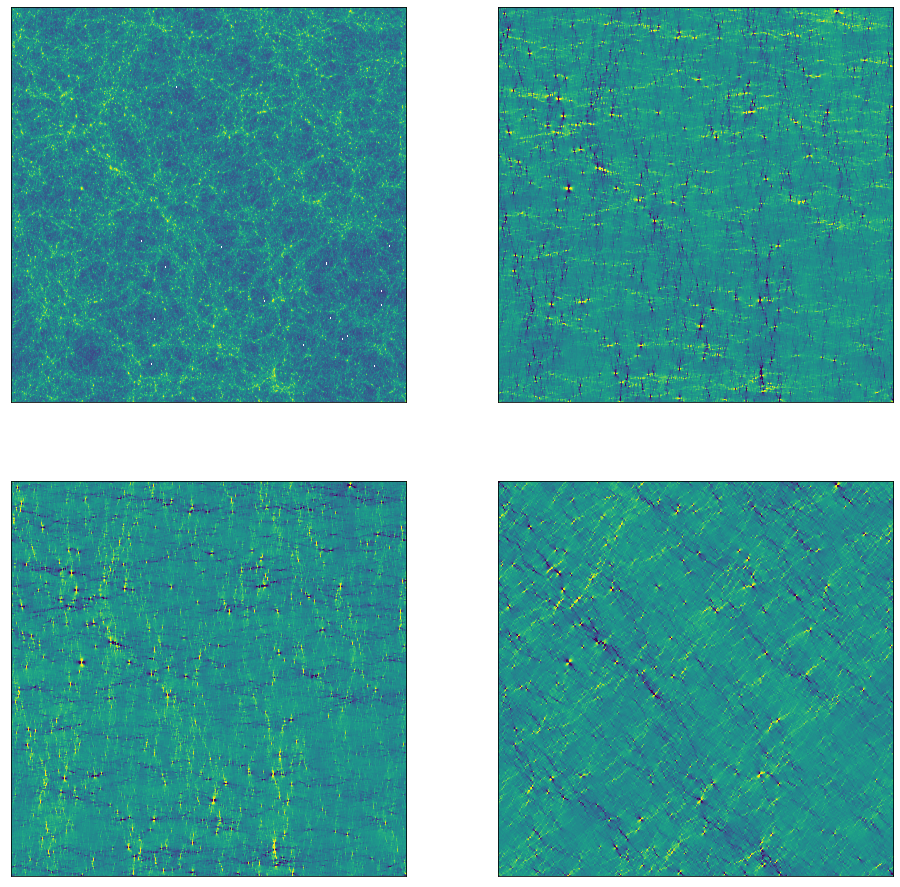

<Figure size 432x288 with 0 Axes>

In [23]:

fig11 = plt.figure(figsize=(16, 16), constrained_layout=False)

# gridspec inside gridspec
outer_grid = fig11.add_gridspec(3, 2, wspace=0.0, hspace=0.0)

ax = fig11.add_subplot(2,2,1)
ax.imshow(np.log(den_map),vmin=2, vmax=7)
ax.set_xticks([])
ax.set_yticks([])
fig11.add_subplot(ax)

ax = fig11.add_subplot(2,2,2)
ax.imshow(s[:,:,0,0],vmin=-0.01, vmax=0.01)
ax.set_xticks([])
ax.set_yticks([])
fig11.add_subplot(ax)

ax = fig11.add_subplot(2,2,3)
ax.imshow(s[:,:,1,1],vmin=-0.01, vmax=0.01)
ax.set_xticks([])
ax.set_yticks([])
fig11.add_subplot(ax)


ax = fig11.add_subplot(2,2,4)
ax.imshow(s[:,:,1,0],vmin=-0.01, vmax=0.01)
ax.set_xticks([])
ax.set_yticks([])
fig11.add_subplot(ax)



#all_axes = fig11.get_axes()
plt.show()

#plt.savefig("../Plots/0.043tidal.pdf")
plt.savefig("../Plots/0.043tidal_smoothing.pdf")


